In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import snapatac2 as snap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pyranges as pr
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.cluster import KMeans
from scipy.stats import spearmanr, gaussian_kde, ttest_ind
from plotnine import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def cut_qc_metrics_by_called(sample_name, figsize = (15,5), mode = 'gex'):

    id_files = [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_outs") if "called_ids" in file.name]
    called_ids = pd.read_csv([f for f in id_files if  sample_name in f.name][0]).reset_index().groupby("CB").UMI.count().to_frame("n_guides")
    called_ids.index = called_ids.index.map(lambda cb: cb + "-1")

    if mode == 'gex':

        adata_files = [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/") if sample_name in file.name]
        adata_path = adata_files[0].path + '/outs/filtered_feature_bc_matrix.h5'

        adata = sc.read_10x_h5(adata_path)
        adata.var_names_make_unique()
        adata.var["mito"] = adata.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(adata, inplace=True, qc_vars = ["mito"])
        
        merge = adata.obs.join(called_ids, how = 'left')
        merge["called"] = merge["n_guides"].fillna(0).map(lambda n: n > 0)
        merge.drop_duplicates(inplace = True)

        fig, ax = plt.subplots(1, 3, figsize=figsize)
        sns.histplot(data = merge, x = 'log1p_total_counts', kde = True, hue = 'called', ax = ax[0])
        sns.histplot(data = merge, x = 'log1p_n_genes_by_counts', kde = True, hue = 'called', ax = ax[1])
        sns.histplot(data = merge, x = 'pct_counts_mito', kde = True, hue = 'called', ax = ax[2])
        ax[2].set_xlim([-2,50])
        fig.suptitle(f"{sample_name} GEX QC metrics by guide call")
        fig.show()

    elif mode == 'atac':

        adata_files = [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files") if sample_name in file.name and 'preprocessed_atac' in file.name]
        adata = snap.read(adata_files[0].path, backed = None)
        merge = adata.obs.join(called_ids, how = 'left')
        merge["called"] = merge["n_guides"].fillna(0).map(lambda n: n > 0)
        merge.drop_duplicates(inplace = True)

        fig, ax = plt.subplots(1, 2, figsize=figsize)
        sns.histplot(data = merge, x = 'n_fragment', kde = True, hue = 'called', ax = ax[0])
        ax[0].set_xlim([0,1e5])
        sns.histplot(data = merge, x = 'tsse', kde = True, hue = 'called', ax = ax[1])
        fig.suptitle(f"{sample_name} ATAC QC metrics by guide call")
        fig.show()

    return merge

In [ ]:
# generate log1p expression matrix, no z-score, cell cycle not regressed out

adata = snap.read("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files/Lane1_040_preprocessed_atac.h5ad", backed = None)
gexqc_040 = cut_qc_metrics_by_called("Lane1_040")
atacqc_040 = cut_qc_metrics_by_called("Lane1_040", mode = 'atac')
qc040 = gexqc_040.join(atacqc_040.drop(["n_guides", "called"], axis = 1), how = 'inner')
qc040.n_fragment = qc040.n_fragment.astype(int)
singlets_040 = qc040.query("n_guides == 1 and log1p_total_counts > 6 and log1p_n_genes_by_counts > 6 and n_fragment > 1000")
ids_040 = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_outs/Lane1_040_called_ids.csv")
ids_040['n_guides'] = ids_040.groupby('CB').UMI.transform('count')
ids_040 = ids_040.query('n_guides == 1')
ids_040['guide_target'] = ids_040['identity'].map(lambda s: s.split("_")[0])
ids_040['CB'] = ids_040.CB.map(lambda b: b + "-1")
ids_040.set_index('CB', inplace = True)
singlets_040 = singlets_040.join(ids_040['guide_target'], how = 'left')
assert len(singlets_040) == 4724

gex = sc.read_10x_h5("/data/norman/eli/T7/202404_SIRLOIN_multiome/Lane1_040/outs/filtered_feature_bc_matrix.h5")
gex.var_names_make_unique()
gex = gex[gex.obs.index.isin(singlets_040.index)]
gex.obs = gex.obs.join(singlets_040, how = 'right')
sc.pp.filter_genes(gex, min_cells = 100)
gex = gex[:, ~gex.var_names.str.contains("MT-")]
sc.pp.normalize_total(gex, target_sum=1e6)
sc.pp.log1p(gex)

In [4]:
# get modeled program genes

preds = pd.concat([pd.read_csv("/scratch/eli/AutogluonModels/scaled/test_preds_scaled_first129.csv"), pd.read_csv("/scratch/eli/AutogluonModels/scaled/test_preds.csv")], axis = 0)
preds['guide_target'] = preds.cluster.map(lambda s: s.split("_")[0])
preds['perturbed'] = preds.guide_target.map(lambda g: 'control' if g == 'NTC' else 'perturbed')
preds['complex'] = preds.guide_target.map(lambda g: 'NuA4' if g in ['ACTL6A', 'DMAP1', 'EP400'] else 'Poly' if g in ['EZH2', 'SUZ12', 'YY1'] else 'NTC' if g == 'NTC' else 'BAF')
preds['complex'] = pd.Categorical(preds.complex, categories=['NuA4', 'BAF', 'Poly', 'NTC'], ordered = True)
preds[['obs_expr', 'pred_expr']] = preds[['obs_expr', 'pred_expr']].map(lambda x: 100 * x)
performance = preds[['target_gene', 'test_spearman']].reset_index(drop=True).drop_duplicates()

gtf = pr.read_gtf('/fscratch/eli/genomes/refdata-gex-GRCh38-2020-A/genes/genes.gtf')[["Chromosome", "Feature", "Start", "End", "gene_id", "gene_type", "gene_name"]]
gtf = gtf[gtf.Feature == 'gene']
protein_coding = [g for g in gtf.df.query("gene_type == 'protein_coding'").gene_name.unique() if g.find('.') == -1]

program_features = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/supplementary_outs/TableS4_feature_weights.csv")
top_genes_in_100 = [p for p in program_features.groupby('program_id').apply(lambda x: x.nlargest(100, 'weight')).query('feature_type == "gene"').feature.unique() if p in protein_coding]
print(len(top_genes_in_100))
prgm_performance = performance.query("target_gene.isin(@top_genes_in_100)")

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


457


/tmp/ipykernel_160133/2230434065.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [5]:
# get initially modeled (random) control genes

ctrl = pd.read_csv("/scratch/eli/AutogluonModels/scaled_ctrl_genes/test_preds.csv")
ctrl_performance = ctrl[['target_gene', 'test_spearman']].reset_index(drop=True).drop_duplicates()
ctrl_performance = ctrl_performance.set_index("target_gene").join(gex[:, gex.var_names.isin(ctrl_performance.target_gene)].to_df().mean().to_frame("mean_expr"))
ctrl_performance['expression_percentile'] = ctrl_performance.mean_expr.rank(pct=True)

In [6]:
# remove lower-expression control genes, then sample new control genes with higher expression based on probability density fit to program genes

old_ctrls = ctrl_performance.query("not index.isin(@program_features.feature_peak_associated) and expression_percentile > 0.3")

degs = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/supplementary_outs/TableS2_differential_genes.csv")
df_new_ctrls = gex[:, ~gex.var_names.isin(degs.gene.unique())].to_df().mean().to_frame("mean_expr").reset_index().rename(columns = {'index': 'gene'}).sort_values('mean_expr', ascending = False).query("gene.isin(@protein_coding) and mean_expr > 2 and not gene.isin(@program_features.feature_peak_associated)")

df_program_expr = gex[:, gex.var_names.isin(prgm_performance.target_gene)].to_df().mean().to_frame("mean_expr")
kde = gaussian_kde(df_program_expr.query("mean_expr > 4").mean_expr)
df_new_ctrls['sample_weight'] = kde(df_new_ctrls.mean_expr) ** 0.5
sampled_ctrls = df_new_ctrls.sample(n = 150, weights = 'sample_weight', random_state = 1)

In [7]:
# handle extra control genes from resampling

df_ctrls = pd.concat([old_ctrls[['mean_expr']].query("not index.isin(@sampled_ctrls)"), sampled_ctrls.set_index('gene')[['mean_expr']]], axis = 0).drop_duplicates().sample(n = len(prgm_performance), random_state = 1)
assert df_ctrls.index.nunique() == len(prgm_performance)

2024-10-10 13:02:15 - INFO - maxp pruned
2024-10-10 13:02:15 - INFO - cmap pruned
2024-10-10 13:02:15 - INFO - post pruned
2024-10-10 13:02:15 - INFO - FFTM dropped
2024-10-10 13:02:15 - INFO - GPOS pruned
2024-10-10 13:02:15 - INFO - GSUB pruned
2024-10-10 13:02:15 - INFO - name pruned
2024-10-10 13:02:15 - INFO - glyf pruned
2024-10-10 13:02:15 - INFO - Added gid0 to subset
2024-10-10 13:02:15 - INFO - Added first four glyphs to subset
2024-10-10 13:02:15 - INFO - Closing glyph list over 'GSUB': 39 glyphs before
2024-10-10 13:02:15 - INFO - Glyph names: ['.notdef', '.null', 'C', 'M', 'N', 'P', 'T', 'a', 'b', 'comma', 'e', 'eight', 'f', 'five', 'four', 'g', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'uni0008', 'x', 'zero']
2024-10-10 13:02:15 - INFO - Glyph IDs:   [0, 1, 2, 3, 5, 13, 14, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 50, 51, 53, 57, 70, 71, 74, 75, 76, 78, 81

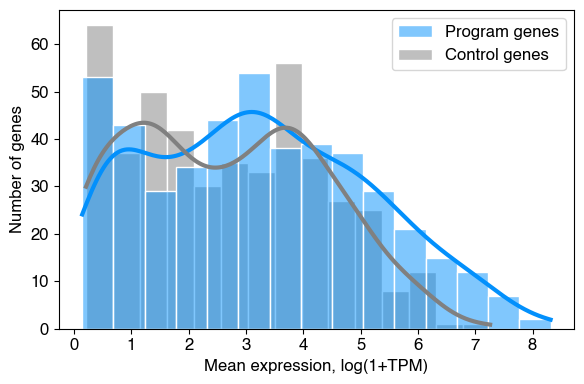

In [35]:
# expression distributions

plt.figure(figsize = (6,4))
sns.histplot(data = df_program_expr, x = 'mean_expr', color = '#0390fc', alpha = 0.5, kde = True, edgecolor = 'white', line_kws={'linewidth': 3}, label = "Program genes", zorder = 2, bins = 15)
sns.histplot(data = df_ctrls, x = 'mean_expr', color = 'grey', alpha = 0.5, kde = True, edgecolor = 'white', line_kws={'linewidth': 3, 'color': 'darkgrey'}, label = 'Control genes', bins = 15)
plt.xlabel("Mean expression, log(1+TPM)")
plt.ylabel("Number of genes")
plt.legend()
plt.tight_layout()
plt.savefig("outs/S7a_expression_distributions.pdf")
plt.show()

In [ ]:
# write out newly sampled genes to train new models

with open("/scratch/eli/AutogluonModels/new_ctrl_expr_matched.txt", 'w') as f:
    f.write("\n".join(sampled_ctrls.gene))

In [36]:
# write out expression-matched control performance for Fig. 2k

new_ctrl_performance = pd.read_csv("/scratch/eli/AutogluonModels/new_ctrl_expr_matched/test_preds.csv")[['target_gene', 'test_spearman']].reset_index(drop=True).drop_duplicates().set_index("target_gene")
ctrl_performance_updated = pd.concat([ctrl_performance.query("target_gene.isin(@df_ctrls.index)"), new_ctrl_performance], axis = 0)
ctrl_performance_updated = ctrl_performance_updated[['test_spearman']].join(df_ctrls.mean_expr)
ctrl_performance_updated.to_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files/autogluon_ctrl_genes_expr_matched.csv")

In [41]:
# relationship between performance and mean expression

# prgm_performance = prgm_performance.set_index('target_gene').join(gex[:, gex.var_names.isin(prgm_performance.target_gene)].to_df().mean().to_frame("mean_expr")).sort_values('test_spearman', ascending = False)
ctrl_performance_updated['gene_set'] = 'Control genes'
prgm_performance['gene_set'] = 'Program genes'
df_performance = pd.concat([ctrl_performance_updated, prgm_performance], axis = 0)

2024-10-10 13:04:00 - INFO - maxp pruned
2024-10-10 13:04:00 - INFO - cmap pruned
2024-10-10 13:04:00 - INFO - post pruned
2024-10-10 13:04:00 - INFO - FFTM dropped
2024-10-10 13:04:00 - INFO - GPOS pruned
2024-10-10 13:04:00 - INFO - GSUB pruned
2024-10-10 13:04:00 - INFO - name pruned
2024-10-10 13:04:00 - INFO - glyf pruned
2024-10-10 13:04:00 - INFO - Added gid0 to subset
2024-10-10 13:04:00 - INFO - Added first four glyphs to subset
2024-10-10 13:04:00 - INFO - Closing glyph list over 'GSUB': 42 glyphs before
2024-10-10 13:04:00 - INFO - Glyph names: ['.notdef', '.null', 'C', 'M', 'P', 'S', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'uni0008', 'x', 'zero']
2024-10-10 13:04:00 - INFO - Glyph IDs:   [0, 1, 2, 3, 5, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 50, 53, 5

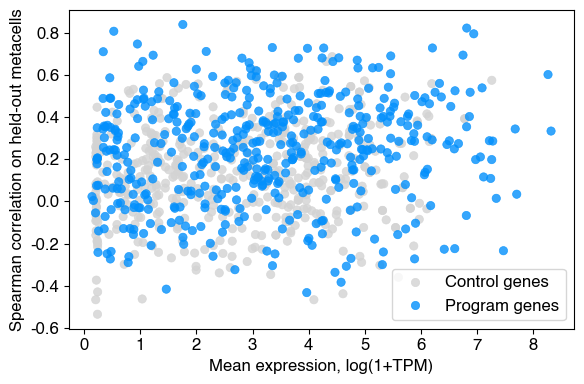

In [42]:
plt.figure(figsize = (6,4))
p = sns.scatterplot(df_performance, x = 'mean_expr', y = 'test_spearman', hue = 'gene_set', edgecolor = None, palette = ['#d3d3d3', '#0390fc'], alpha = 0.8)
p.legend(title = None)
plt.xlabel("Mean expression, log(1+TPM)")
plt.ylabel("Spearman correlation on held-out metacells")
plt.tight_layout()
plt.savefig("outs/S7b_expression_performance.pdf")
plt.show()

2024-10-10 12:49:17 - INFO - maxp pruned
2024-10-10 12:49:17 - INFO - cmap pruned
2024-10-10 12:49:17 - INFO - post pruned
2024-10-10 12:49:17 - INFO - FFTM dropped
2024-10-10 12:49:17 - INFO - GPOS pruned
2024-10-10 12:49:17 - INFO - GSUB pruned
2024-10-10 12:49:17 - INFO - name pruned
2024-10-10 12:49:17 - INFO - glyf pruned
2024-10-10 12:49:17 - INFO - Added gid0 to subset
2024-10-10 12:49:17 - INFO - Added first four glyphs to subset
2024-10-10 12:49:17 - INFO - Closing glyph list over 'GSUB': 38 glyphs before
2024-10-10 12:49:17 - INFO - Glyph names: ['.notdef', '.null', 'C', 'N', 'P', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'uni0008', 'zero']
2024-10-10 12:49:17 - INFO - Glyph IDs:   [0, 1, 2, 3, 5, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 51, 53, 56, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81, 82, 83, 84, 85, 8

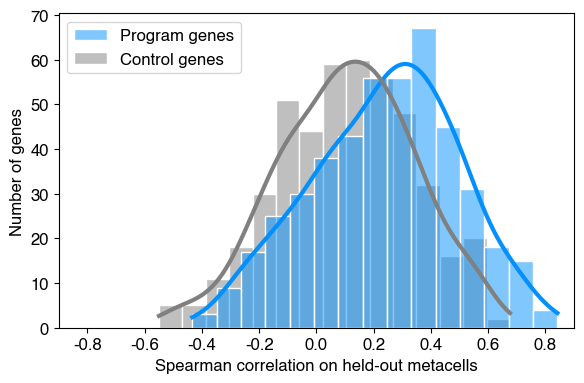

In [15]:
# performance comparison in randomly sampled control genes with no consideration of expression level

random_ctrls = ctrl_performance.sample(len(prgm_performance), random_state = 10)

plt.figure(figsize = (6,4))
sns.histplot(data = prgm_performance, x = 'test_spearman', color = '#0390fc', alpha = 0.5, kde = True, bins = 15, edgecolor = 'white', line_kws={'linewidth': 3}, label = "Program genes", zorder = 2)
sns.histplot(data = random_ctrls, x = 'test_spearman', color = 'grey', alpha = 0.5, kde = True, bins = 15, edgecolor = 'white', line_kws={'linewidth': 3, 'color': 'darkgrey'}, label = 'Control genes')
plt.xlim(-0.9, 0.9)
plt.xlabel("Spearman correlation on held-out metacells")
plt.ylabel("Number of genes")
plt.legend()
plt.tight_layout()
plt.savefig("outs/S7c_autogluon_performance_random.pdf")
plt.show()